In [1]:
import warnings
warnings.filterwarnings('ignore')


from obp.policy import Random, BernoulliTS
from obp.ope import RegressionModel
from sklearn.neural_network import MLPRegressor as MLPR

import numpy as np
import pandas as pd
from tqdm import tqdm

from dataset.real import ModifiedZOZOTOWNBanditDataset
from ope.regression import PairWiseRegression
from ope.estimator import InversePropensityScore as IPS
from ope.estimator import MarginalizedIPS as MIPS
from ope.estimator import DoublyRobust as DR
from ope.estimator import DirectMethod as DM
from ope.estimator import OFFCEM
from ope.estimator_tuning import SLOPE
from ope.meta import OffPolicyEvaluation
from ope.importance_weight import marginal_weight_over_embedding_spaces
from utils.common import visualize_cdf_of_ralative_error
from utils.common import aggregate_simulation_results
from utils.lower_bound import estimate_student_t_lower_bound

In [2]:
# settings

sample_sizes = [3000]

n_actions=80
len_list=3
n_actions_all = n_actions * len_list
n_clusters=5
random_state=12345
n_seeds=100
n_cat_dim=4
ope_estimators = [
    IPS(estimator_name="IPS"),
    DM(estimator_name="DM"),
    DR(estimator_name="DR"),
    OFFCEM(estimator_name="OFFCEM"),
    OFFCEM(estimator_name="OFFCEM + 1-step reg"),
    OFFCEM(estimator_name="OFFCEM + cluster")
]

ope_estimators_tune = [
    SLOPE(
        estimator=MIPS(estimator_name="MIPS (true) w/SLOPE"),
        hyper_param=np.arange(n_cat_dim),
        param_name="action_embed_dim",
        lower_bound_func=estimate_student_t_lower_bound,
        weight_func=marginal_weight_over_embedding_spaces,
        tuning_method="greedy_combination",
        min_combination=1
    )
]

In [3]:
pi_ur = Random(
    n_actions=n_actions,
    len_list=len_list,
    random_state=random_state,
)
pi_ts = BernoulliTS(
    n_actions=n_actions,
    len_list=len_list,
    random_state=random_state,
    is_zozotown_prior=True,
    campaign="all",
)

# calc ground-truth policy value (on-policy)
policy_value = ModifiedZOZOTOWNBanditDataset.calc_on_policy_policy_value_estimate(
    behavior_policy="bts", campaign="all"
)

# define a dataset class
dataset = ModifiedZOZOTOWNBanditDataset(
    behavior_policy="random",
    campaign="all",
    n_clusters=n_clusters
)

result_df_list = []
for sample_size in sample_sizes:
    
    pi_b = pi_ur.compute_batch_action_dist(n_rounds=sample_size)
    pi_b = pi_b.reshape(sample_size, n_actions * len_list) / len_list

    pi_e = pi_ts.compute_batch_action_dist(n_rounds=sample_size)
    pi_e = pi_e.reshape(sample_size, n_actions * len_list) / len_list

    result_list = []
    for seed in tqdm(range(n_seeds), desc=f"sample_size={sample_size}..."):

        val_data = dataset.sample_bootstrap_bandit_feedback(
            sample_size=sample_size,
            random_state=seed
        )
        val_data["pi_b"] = pi_b

        # off policy evaluation
        ope = OffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators,
            ope_estimators_tune=ope_estimators_tune
        )
        
        ## train_reward_via_two_stage
        ### 1st-stage
        pairwise_model = PairWiseRegression(
            dim_context=val_data["dim_context"],
            n_actions=n_actions_all,
            n_clusters=n_clusters,
            hidden_layer_size=(10, 10, 10),
            learning_rate_init=0.1,
            max_iter=10,
            #verbose=True
        )
        h_hat = pairwise_model.fit_predict(bandit_data=val_data)
        
        ### 2nd-stage
        reward = val_data["reward"]
        reward_residual = reward - h_hat[np.arange(sample_size), val_data["action"]]
        cluster, phi_x_a = val_data["cluster"], val_data["phi_x_a"]

        reg_model = RegressionModel(
            n_actions=n_clusters,
            action_context=np.eye(n_clusters),
            base_model=MLPR(
                hidden_layer_sizes=(10, 10, 10), 
                max_iter=10, 
                random_state=12345, 
                #verbose=True,
                learning_rate_init=0.1,
            )
        )

        g_hat = reg_model.fit_predict(
            context=val_data["context"],
            action=cluster,
            reward=reward_residual
        )[:, :, 0]

        f_hat_x_a_e = h_hat + g_hat[np.arange(sample_size)[:, None], phi_x_a]
        
        ## one-step reward regression
        reg_model = RegressionModel(
            n_actions=n_actions_all,
            action_context=val_data["action_context_one_hot"],
            base_model=MLPR(
                hidden_layer_sizes=(10, 10, 10), 
                max_iter=10, 
                random_state=12345, 
                #verbose=True,
                learning_rate_init=0.1,
            )
        )
        q_hat_x_a = reg_model.fit_predict(
            context=val_data["context"],
            action=val_data["action"],
            reward=val_data["reward"],
        )[:, :, 0]
        
        q_hat_dict = {
            "DM": q_hat_x_a,
            "DR": q_hat_x_a,
            "OFFCEM": f_hat_x_a_e,
            "OFFCEM + 1-step reg": q_hat_x_a,
            "OFFCEM + cluster": np.zeros_like(q_hat_x_a),
        }
        
        
        estimated_policy_values = ope.estimate_policy_values(action_dist=pi_e, estimated_rewards=q_hat_dict)

        result_list.append(estimated_policy_values)

    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=sample_size
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.
INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.
sample_size=3000...: 100% 100/100 [18:57<00:00, 11.37s/it]


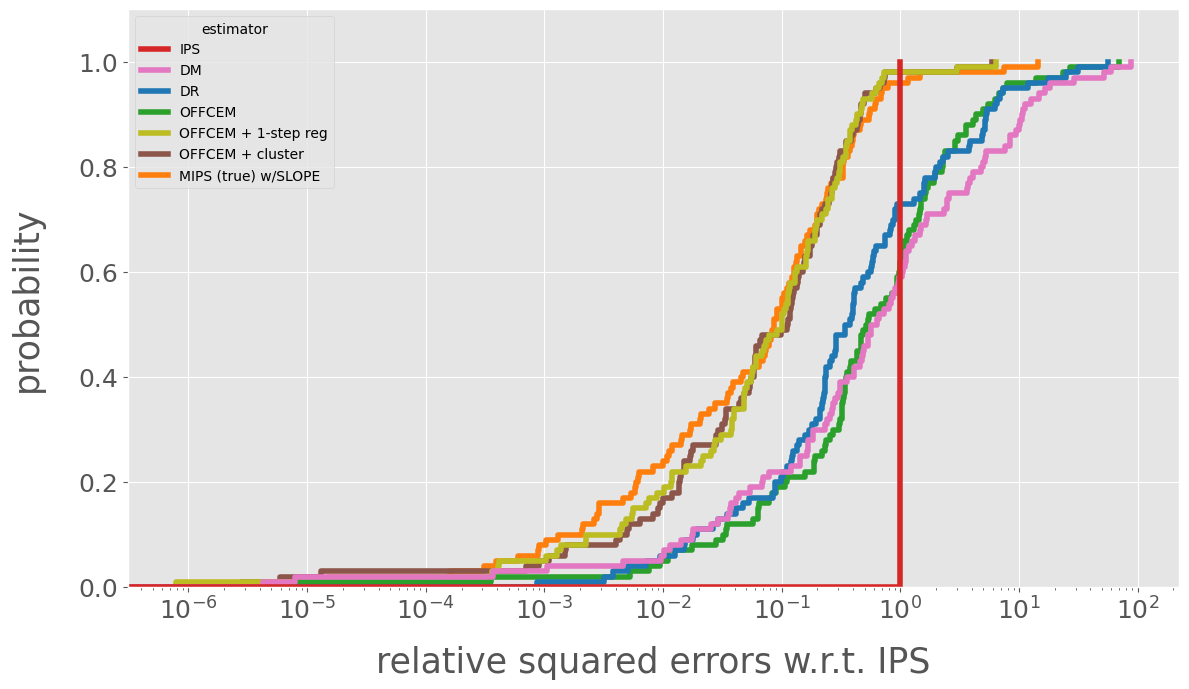

In [4]:
### CDF of relative SE ###
sample_size_mask = (result_df["x"] == 3000)
rel_result_df = result_df[sample_size_mask].copy()

visualize_cdf_of_ralative_error(rel_result_df, baseline="IPS")

In [5]:
ope.ope_estimators_tune[0].best_param

{0}

In [6]:
policy_value

0.0042

In [7]:
result_df.groupby(["estimator", "x"]).agg({"value": "mean"})

,,value
estimator,x,
DM,3000,0.004972
DR,3000,0.004531
IPS,3000,0.001185
MIPS (true) w/SLOPE,3000,0.004124
OFFCEM,3000,0.004041
OFFCEM + 1-step reg,3000,0.003749
OFFCEM + cluster,3000,0.003660


In [8]:
result_df.groupby(["estimator", "x"]).agg({"bias": "mean"}) ** 2

,,bias
estimator,x,
DM,3000,3.554877e-13
DR,3000,1.196352e-14
IPS,3000,8.261485e-11
MIPS (true) w/SLOPE,3000,3.329608e-17
OFFCEM,3000,6.441062e-16
OFFCEM + 1-step reg,3000,4.128114e-14
OFFCEM + cluster,3000,8.514927e-14


In [9]:
# OFFCEM achieved the lowest bias compared to other OFFCEM ablations.

In [10]:
result_df.groupby(["estimator", "x"]).agg({"value": "var"})

,,value
estimator,x,
DM,3000,2.948101e-05
DR,3000,1.491176e-05
IPS,3000,3.986476e-07
MIPS (true) w/SLOPE,3000,1.816919e-06
OFFCEM,3000,1.551276e-05
OFFCEM + 1-step reg,3000,1.384133e-06
OFFCEM + cluster,3000,1.288960e-06


In [11]:
result_df.groupby(["estimator", "x"]).agg({"se": "mean"})["se"].to_dict()

{('DM', 3000): 2.9782428713538537e-05,
 ('DR', 3000): 1.4872015971987077e-05,
 ('IPS', 3000): 9.483932067318518e-06,
 ('MIPS (true) w/SLOPE', 3000): 1.804519758309789e-06,
 ('OFFCEM', 3000): 1.538301085567413e-05,
 ('OFFCEM + 1-step reg', 3000): 1.5734691922460306e-06,
 ('OFFCEM + cluster', 3000): 1.5678734842676008e-06}

In [12]:
# "OFFCEM + cluster" achieved the lowest MSE and highest probability compared to other estimators
# because rewards are binary and then "OFFCEM + cluster" maintain the low bias 